In [5]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.affinity import scale
from shapely.geometry import MultiPolygon, Point, Polygon, box

In [6]:
def S_get_gdf() -> gpd.GeoDataFrame:
    """取得gml檔案，並轉換成gdf物件"""
    folder = Path(r"C:\Users\add41\Documents\Data_Engineer\Project\example_data")
    file_name = "COUNTY_MOI_1140318.gml"
    path = folder / file_name

    gdf = gpd.read_file(path)

    return gdf


def S_get_city_geodata(city_name: str):
    """輸入縣市名稱，取得該縣市的地理資料"""
    gdf = S_get_gdf()
    city_idx = gdf[gdf["名稱"] == city_name].index
    geo_data = gdf.loc[city_idx].geometry.values[0]

    return geo_data


def create_circle(point, radius_lat, radius_lon):
    # 先將點轉成shapely Point
    # buffer會產生圓形，但單一半徑，經緯度比例不同需調整
    circle = point.buffer(radius_lat)  # 先用緯度半徑畫圓
    # 接著用scale調整x軸比例，變成橢圓形，近似真實圓
    circle = scale(circle, xfact=radius_lon/radius_lat, yfact=1, origin=point)
    return circle


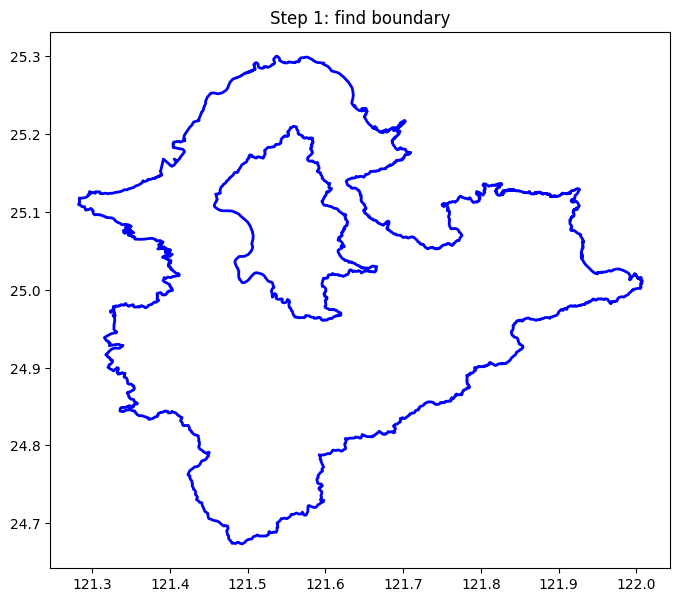

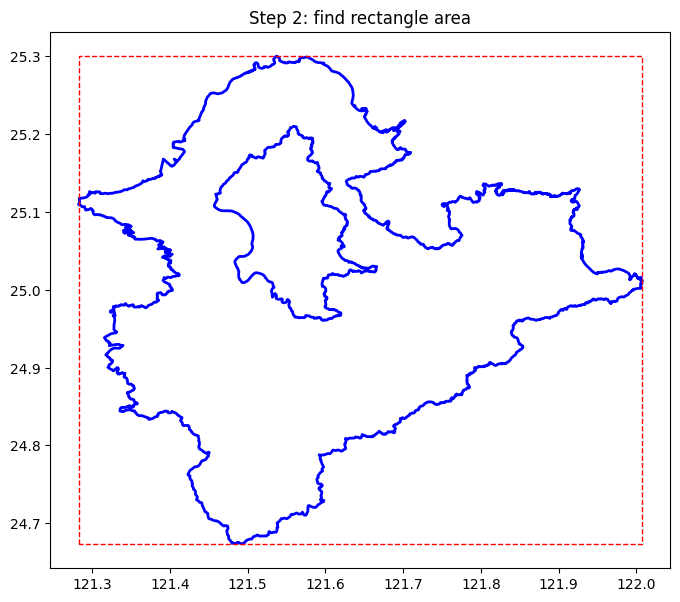

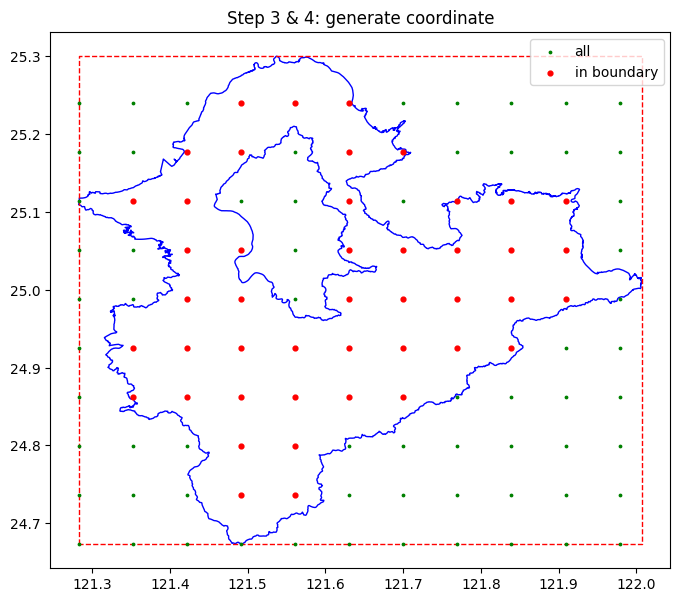

In [ ]:
# 假設 S_get_city_geodata(city_name) 回傳的是 shapely MultiPolygon
city_boundary = S_get_city_geodata("新北市")

# 將 MultiPolygon 包成 GeoSeries，方便繪圖
city_gs = gpd.GeoSeries([city_boundary])

# 1. 畫出縣市邊界
fig, ax = plt.subplots(figsize=(8, 8))
city_gs.plot(ax=ax, color='none', edgecolor='blue', linewidth=2)
ax.set_title("Step 1: find boundary")

plt.savefig(r"C:\Users\add41\Documents\Data_Engineer\Project\example_data\nearby_search\step1.png", dpi=160, bbox_inches='tight')

plt.show()

# 2. 劃出矩形範圍（四極點形成的矩形）
min_x, min_y, max_x, max_y = city_boundary.bounds
rect = box(min_x, min_y, max_x, max_y)
rect_gs = gpd.GeoSeries([rect])

fig, ax = plt.subplots(figsize=(8, 8))
city_gs.plot(ax=ax, color='none', edgecolor='blue', linewidth=2)
rect_gs.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='--')
ax.set_title("Step 2: find rectangle area")

plt.savefig(r"C:\Users\add41\Documents\Data_Engineer\Project\example_data\nearby_search\step2.png", dpi=160, bbox_inches='tight')

plt.show()

# 3. 產生座標點（以step為例）
step_m = 7000  # 1公里
lat_step = step_m / 111000
lon_step = step_m / (111000 * np.cos(np.radians((min_y + max_y) / 2)))

lat_points = np.arange(min_y, max_y, lat_step)
lon_points = np.arange(min_x, max_x, lon_step)

points = [Point(lon, lat) for lat in lat_points for lon in lon_points]
points_gdf = gpd.GeoDataFrame(geometry=points)

# 4. 標示出落在縣市範圍內的點
inside_points = points_gdf[points_gdf.within(city_boundary)]

fig, ax = plt.subplots(figsize=(8, 8))
city_gs.plot(ax=ax, color='none', edgecolor='blue')
rect_gs.plot(ax=ax, facecolor='none', edgecolor='red', linestyle='--')
points_gdf.plot(ax=ax, color='green', markersize=3, label='all')
inside_points.plot(ax=ax, color='red', markersize=12, label='in boundary')
ax.legend()
ax.set_title("Step 3 & 4: generate coordinate")

plt.savefig(r"C:\Users\add41\Documents\Data_Engineer\Project\example_data\nearby_search\step3+4.png", dpi=160, bbox_inches='tight')

plt.show()

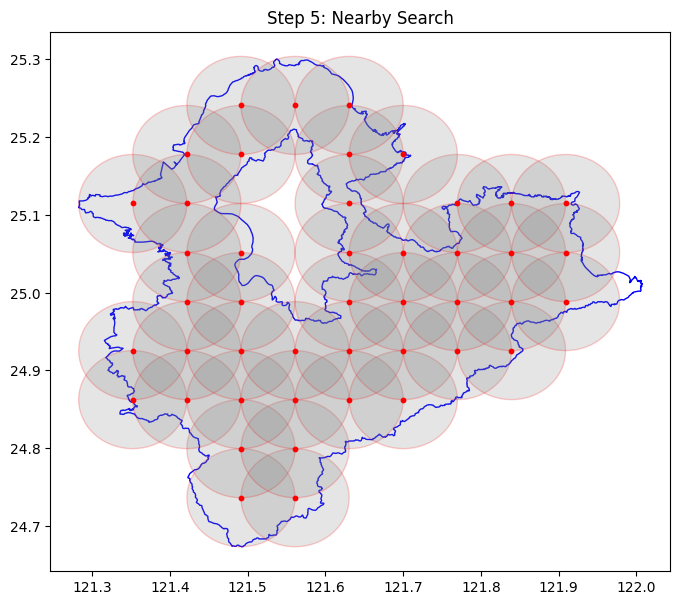

In [8]:
# 中心緯度（用邊界中點）
center_lat = (city_boundary.bounds[1] + city_boundary.bounds[3]) / 2

# 公尺轉緯度約1度 = 111000公尺
radius_lat = step_m / 111000

# 公尺轉經度要考慮緯度縮放
radius_lon = step_m / (111000 * np.cos(np.radians(center_lat)))

# 產生每個點的圓形
circles = inside_points.geometry.apply(lambda p: create_circle(p, radius_lat, radius_lon))

# 把圓形放入 GeoDataFrame
circles_gdf = gpd.GeoDataFrame(geometry=circles)

# 繪圖
fig, ax = plt.subplots(figsize=(8, 8))
gpd.GeoSeries([city_boundary]).plot(ax=ax, color='none', edgecolor='blue')
circles_gdf.plot(ax=ax, facecolor='gray', edgecolor='red', alpha=0.2)  # 填充灰色，透明度0.3
inside_points.plot(ax=ax, color='red', markersize=10)
ax.set_title("Step 5: Nearby Search")

plt.savefig(r"C:\Users\add41\Documents\Data_Engineer\Project\example_data\nearby_search\step5.png", dpi=160, bbox_inches='tight')

plt.show()